In [1]:
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
# import matplotlib_scalebar
# from matplotlib_scalebar.scalebar import ScaleBar
import numpy
# import ortools
# from ortools.linear_solver import pywraplp
# import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

# n clients and n facilities
client_count, facility_count = 400, 14

# candidate facilites to site
p_facilities = 3

# maximum coverage meters
max_coverage = 1000.0

# minimum coverage meters
min_coverage = 800.0

random_seeds = {"client": 3006, "facility": 1520}

title = "Neighborhood X"

streets = geopandas.read_file(examples.get_path("streets.shp"))
streets.crs = "esri:102649"
streets = streets.to_crs("epsg:2762")
streets.head()

,ID,Length,geometry
0,1.0,244.116229,"LINESTRING (222007.131 267348.711, 222007.159 ..."
1,2.0,375.974828,"LINESTRING (222006.951 267549.880, 222007.131 ..."
2,3.0,400.353405,"LINESTRING (221420.428 267804.889, 221411.402 ..."
3,4.0,660.000000,"LINESTRING (220875.116 268353.388, 220803.948 ..."
4,5.0,660.000000,"LINESTRING (220802.426 268398.824, 220917.000 ..."


In [2]:
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

buff = 50
streets_buffer = get_buffer(streets, buff=buff)
streets_buffer

,geometry
0,"POLYGON ((221824.140 268653.724, 221824.140 26..."


In [3]:
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.s
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts

clients = simulated_geo_points(
    streets_buffer, needed=client_count, seed=random_seeds["client"]
)
facilities = simulated_geo_points(
    streets_buffer, needed=facility_count, seed=random_seeds["facility"]
)

In [4]:
clients["dv"] = ["x[%s]" % c for c in range(client_count)]
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]


In [5]:
numpy.random.seed(1991)
clients["weights"] = numpy.random.randint(1, 8, (client_count, 1))
clients.head()

,geometry,dv,weights
0,POINT (220621.917 267350.429),x[0],1
1,POINT (220803.166 268060.603),x[1],7
2,POINT (221870.782 268397.667),x[2],4
3,POINT (220715.998 267148.323),x[3],6
4,POINT (221330.455 267985.572),x[4],5


In [6]:
ntw = spaghetti.Network(in_data=streets)

In [7]:
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

In [8]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

In [9]:
from spopt.locate.coverage import LSCP
import pulp
lscp = LSCP.from_cost_matrix(cost_matrix, max_coverage)
status = lscp.solve(pulp.PULP_CBC_CMD())
print(status)

In [10]:
lscp.facility_client_array()

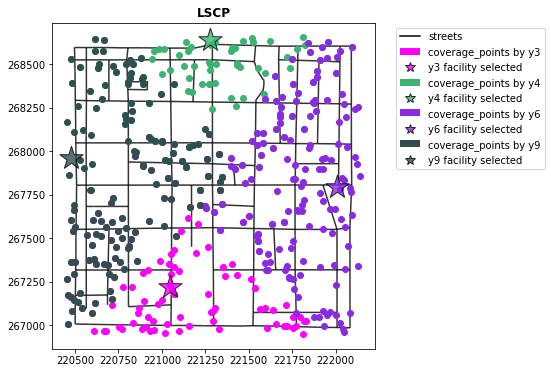

In [27]:
# get list of points
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

arr_points = []
fac_sites = []
dv_colors = [
    "fuchsia",
    "mediumseagreen",
    "blueviolet",
    "darkslategray",
    "lightskyblue",
    "saddlebrown",
    "cyan",
    "darkgoldenrod",
    "limegreen",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "darkcyan",
    "thistle",
    "lavender",
]

for i in range(facility_count):
    if lscp.fac2cli[i]:

        geom = clients.iloc[lscp.fac2cli[i]]['geometry']
        arr_points.append(geom)
        fac_sites.append(i)

fig, ax = plt.subplots(figsize=(6, 6))
legend_elements = []

streets.plot(ax=ax, alpha=0.8, color='black', zorder=1)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='black',
    label='streets',
))

for i in range(len(arr_points)):
    gdf = geopandas.GeoDataFrame(arr_points[i])

    label = f"coverage_points by y{fac_sites[i]}"
    legend_elements.append(Patch(facecolor=dv_colors[i], label=label))

    gdf.plot(ax=ax, zorder=3, color=dv_colors[i], label=label)
    facilities.iloc[[fac_sites[i]]].plot(ax=ax,
                            marker="*",
                            markersize=200 * 3.0,
                            alpha=0.8,
                            zorder=4,
                            edgecolor="k",
                            facecolor=dv_colors[i])
    
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color=dv_colors[i],
        marker="*",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{fac_sites[i]} facility selected",
    ))

plt.title("LSCP", fontweight="bold")
plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))


In [12]:
from spopt.locate.coverage import MCLP
import pulp

ai = clients['weights']
ai = ai.values.reshape(cost_matrix.shape[0], 1)

mclp = MCLP.from_cost_matrix(cost_matrix, ai, max_coverage, p_facilities)
status = mclp.solve(pulp.PULP_CBC_CMD())
print(status)
# for v in model.variables():
#     print(v.name, "=", v.varValue)

In [27]:
mclp.facility_client_array()
mclp.uncovered_clients_dict()
mclp.get_percentage()
print(mclp.percentage)

0.985


/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


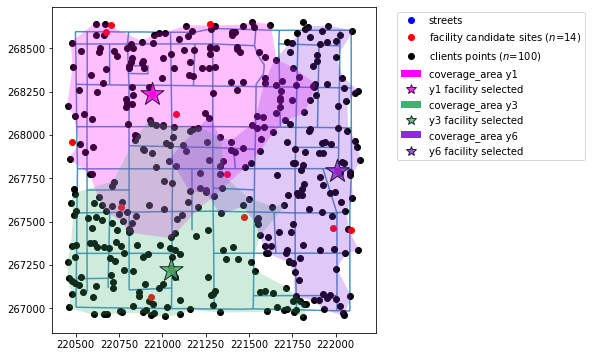

In [36]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

arr_points = []
fac_sites = []
dv_colors = [
    "fuchsia",
    "mediumseagreen",
    "blueviolet",
    "darkslategray",
    "lightskyblue",
    "saddlebrown",
    "cyan",
    "darkgoldenrod",
    "limegreen",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "darkcyan",
    "thistle",
    "lavender",
]

for i in range(facility_count):
    if mclp.fac2cli[i]:
        geom = clients.iloc[mclp.fac2cli[i]]['geometry']
        arr_points.append(geom.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist())
        fac_sites.append(i)

fig, ax = plt.subplots(figsize=(6, 6))
legend_elements = []

streets.plot(ax=ax, alpha=0.8, zorder=1)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='blue',
    marker="o",
    linewidth=0,
    label='streets',
))


facilities.plot(ax=ax, color='red', zorder=2)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='red',
    marker="o",
    linewidth=0,
    label='facility candidate sites ($n$=14)'
))

clients.plot(ax=ax, color='black')
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='black',
    marker="o",
    linewidth=0,
    label='clients points ($n$=100)'
))

for i in range(len(arr_points)):
    ccv = cg.alpha_shape_auto(numpy.vstack(arr_points[i]), step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(5)], columns=["geometry"])

    label = f"coverage_area y{fac_sites[i]}"
    legend_elements.append(Patch(facecolor=dv_colors[i], label=label))

    ccv.plot(ax=ax, zorder=3, alpha=0.25, color=dv_colors[i], label=label)
    facilities.iloc[[fac_sites[i]]].plot(ax=ax,
                            marker="*",
                            markersize=200 * 3.0,
                            alpha=0.8,
                            zorder=4,
                            edgecolor="k",
                            facecolor=dv_colors[i])
    
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color=dv_colors[i],
        marker="*",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{fac_sites[i]} facility selected",
    ))

plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

In [13]:
import pulp
from spopt.locate.p_median import PMedian

# binary coverage matrix from cij
ai = clients['weights']
ai = ai.values.reshape(cost_matrix.shape[0], 1)

pmedian = PMedian.from_cost_matrix(cost_matrix, ai, p_facilities)
status = pmedian.solve(pulp.PULP_CBC_CMD())
print(status)

In [17]:
pmedian.facility_client_array()
pmedian.get_mean_distance(ai)
print(pmedian.mean_dist)
print(pmedian.problem.objective.value())

562.5290979966193
898921.4985985976


/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


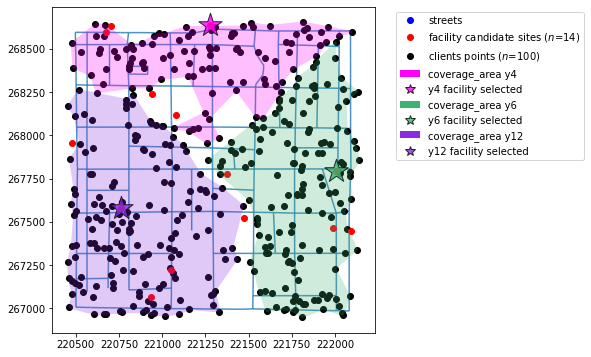

In [35]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

arr_points = []
fac_sites = []
dv_colors = [
    "fuchsia",
    "mediumseagreen",
    "blueviolet",
    "darkslategray",
    "lightskyblue",
    "saddlebrown",
    "cyan",
    "darkgoldenrod",
    "limegreen",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "darkcyan",
    "thistle",
    "lavender",
]

for i in range(facility_count):
    if pmedian.fac2cli[i]:
        geom = clients.iloc[pmedian.fac2cli[i]]['geometry']
        arr_points.append(geom.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist())
        fac_sites.append(i)

fig, ax = plt.subplots(figsize=(6, 6))
legend_elements = []

streets.plot(ax=ax, alpha=0.8, zorder=1)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='blue',
    marker="o",
    linewidth=0,
    label='streets',
))


facilities.plot(ax=ax, color='red', zorder=2)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='red',
    marker="o",
    linewidth=0,
    label='facility candidate sites ($n$=14)'
))

clients.plot(ax=ax, color='black')
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='black',
    marker="o",
    linewidth=0,
    label='clients points ($n$=100)'
))

for i in range(len(arr_points)):
    ccv = cg.alpha_shape_auto(numpy.vstack(arr_points[i]), step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(5)], columns=["geometry"])

    label = f"coverage_area y{fac_sites[i]}"
    legend_elements.append(Patch(facecolor=dv_colors[i], label=label))

    ccv.plot(ax=ax, zorder=3, alpha=0.25, color=dv_colors[i], label=label)
    facilities.iloc[[fac_sites[i]]].plot(ax=ax,
                            marker="*",
                            markersize=200 * 3.0,
                            alpha=0.8,
                            zorder=4,
                            edgecolor="k",
                            facecolor=dv_colors[i])
    
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color=dv_colors[i],
        marker="*",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{fac_sites[i]} facility selected",
    ))

plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

In [19]:
import pulp
from spopt.locate.p_center import PCenter

ai = clients['weights']
ai = ai.values.reshape(cost_matrix.shape[0], 1)

pcenter = PCenter.from_cost_matrix(cost_matrix, ai, p_facilities)
status = pcenter.solve(pulp.PULP_CBC_CMD())
print(status)

In [18]:
print(pcenter.problem.objective.value())

NameError: name 'pcenter' is not defined

In [20]:
pcenter.facility_client_array()

/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/gegen07/anaconda3/envs/spopt/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


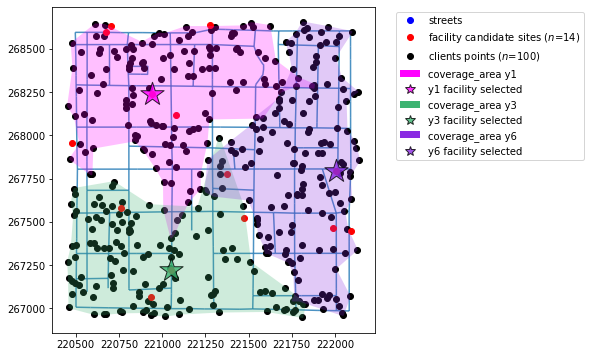

In [34]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

arr_points = []
fac_sites = []
dv_colors = [
    "fuchsia",
    "mediumseagreen",
    "blueviolet",
    "darkslategray",
    "lightskyblue",
    "saddlebrown",
    "cyan",
    "darkgoldenrod",
    "limegreen",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "darkcyan",
    "thistle",
    "lavender",
]

for i in range(facility_count):
    if pcenter.fac2cli[i]:
        geom = clients.iloc[pcenter.fac2cli[i]]['geometry']
        arr_points.append(geom.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist())
        fac_sites.append(i)

fig, ax = plt.subplots(figsize=(6, 6))
legend_elements = []

streets.plot(ax=ax, alpha=0.8, zorder=1)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='blue',
    marker="o",
    linewidth=0,
    label='streets',
))


facilities.plot(ax=ax, color='red', zorder=2)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='red',
    marker="o",
    linewidth=0,
    label='facility candidate sites ($n$=14)'
))

clients.plot(ax=ax, color='black')
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='black',
    marker="o",
    linewidth=0,
    label='clients points ($n$=100)'
))

for i in range(len(arr_points)):
    ccv = cg.alpha_shape_auto(numpy.vstack(arr_points[i]), step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(5)], columns=["geometry"])

    label = f"coverage_area y{fac_sites[i]}"
    legend_elements.append(Patch(facecolor=dv_colors[i], label=label))

    ccv.plot(ax=ax, zorder=3, alpha=0.25, color=dv_colors[i], label=label)
    facilities.iloc[[fac_sites[i]]].plot(ax=ax,
                            marker="*",
                            markersize=200 * 3.0,
                            alpha=0.8,
                            zorder=4,
                            edgecolor="k",
                            facecolor=dv_colors[i])
    
    legend_elements.append(mlines.Line2D(
        [],
        [],
        color=dv_colors[i],
        marker="*",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{fac_sites[i]} facility selected",
    ))

plt.legend(handles = legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))